Final probability norm: 1.000000
Probability at defect site: 0.000804


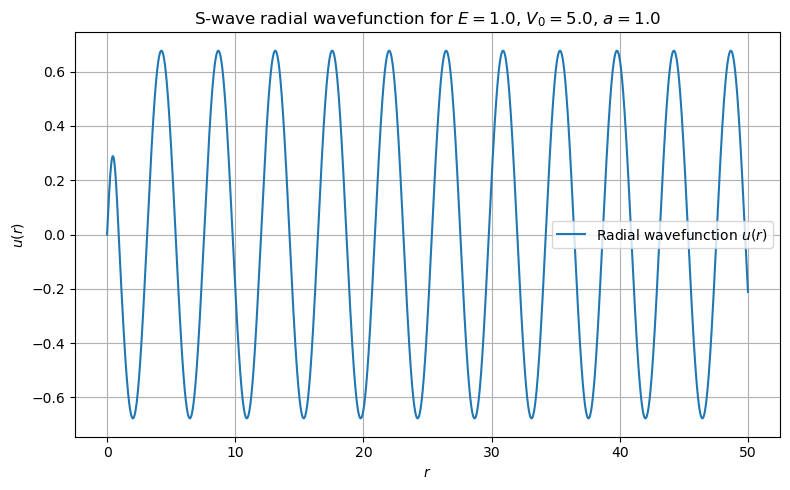

In [ ]:
from typing import Optional, Tuple, List

import numpy as np
from scipy.sparse import csr_matrix, lil_matrix, identity
from scipy.sparse.linalg import splu


def lattice_flat_index(x_index: int, y_index: int, num_sites_y: int) -> int:
    """
    Compute the flat index for a 2D lattice site using row-major order.

    Parameters
    ----------
    x_index : int
        Zero-based x index in [0, num_sites_x).
    y_index : int
        Zero-based y index in [0, num_sites_y).
    num_sites_y : int
        Number of lattice sites along y.

    Returns
    -------
    int
        Flat index in [0, num_sites_x * num_sites_y).
    """
    return x_index * num_sites_y + y_index


def build_tight_binding_hamiltonian(
    num_sites_x: int,
    num_sites_y: int,
    hopping_energy: float = 1.0,
    uniform_onsite_potential: float = 0.0,
    defect_potential: float = 5.0,
    defect_position: Optional[Tuple[int, int]] = None,
    dtype: np.dtype = np.complex128,
) -> csr_matrix:
    """
    Construct a sparse 2D nearest-neighbor tight-binding Hamiltonian on a square lattice
    with open boundary conditions and a single on-site defect potential.

    H = sum_{<i,j>} (-t) |i><j| + h.c. + sum_i V_i |i><i|

    Parameters
    ----------
    num_sites_x : int
        Number of lattice sites along x.
    num_sites_y : int
        Number of lattice sites along y.
    hopping_energy : float, optional
        Nearest-neighbor hopping amplitude t. Default is 1.0.
    uniform_onsite_potential : float, optional
        Uniform on-site potential added to every site. Default is 0.0.
    defect_potential : float, optional
        Additional on-site potential applied at the defect site. Default is 5.0.
    defect_position : Optional[Tuple[int, int]], optional
        Defect site as (x_index, y_index). If None, uses the central site.
    dtype : np.dtype, optional
        Matrix data type. Default is complex128.

    Returns
    -------
    csr_matrix
        The Hamiltonian matrix of shape (N, N) with N = num_sites_x * num_sites_y.
    """
    total_sites = num_sites_x * num_sites_y

    if defect_position is None:
        defect_position = (num_sites_x // 2, num_sites_y // 2)

    matrix_builder = lil_matrix((total_sites, total_sites), dtype=dtype)

    # On-site potentials
    for x_index in range(num_sites_x):
        for y_index in range(num_sites_y):
            flat_index = lattice_flat_index(x_index, y_index, num_sites_y)
            onsite_value: complex = complex(uniform_onsite_potential)
            if (x_index, y_index) == defect_position:
                onsite_value += complex(defect_potential)
            matrix_builder[flat_index, flat_index] = onsite_value

    # Nearest-neighbor hopping (open boundaries)
    t = complex(-hopping_energy)
    for x_index in range(num_sites_x):
        for y_index in range(num_sites_y):
            this_index = lattice_flat_index(x_index, y_index, num_sites_y)

            # +x neighbor
            if x_index + 1 < num_sites_x:
                neighbor_index = lattice_flat_index(x_index + 1, y_index, num_sites_y)
                matrix_builder[this_index, neighbor_index] = t
                matrix_builder[neighbor_index, this_index] = t

            # +y neighbor
            if y_index + 1 < num_sites_y:
                neighbor_index = lattice_flat_index(x_index, y_index + 1, num_sites_y)
                matrix_builder[this_index, neighbor_index] = t
                matrix_builder[neighbor_index, this_index] = t

    return matrix_builder.tocsr()


def gaussian_wavepacket_on_lattice(
    num_sites_x: int,
    num_sites_y: int,
    center_x: float,
    center_y: float,
    standard_deviation: float,
    wavevector_x: float = 0.0,
    wavevector_y: float = 0.0,
    dtype: np.dtype = np.complex128,
) -> np.ndarray:
    """
    Create a normalized Gaussian wavepacket on a 2D lattice.

    Parameters
    ----------
    num_sites_x : int
        Number of lattice sites along x.
    num_sites_y : int
        Number of lattice sites along y.
    center_x : float
        Continuous x center of the Gaussian (in lattice indices).
    center_y : float
        Continuous y center of the Gaussian (in lattice indices).
    standard_deviation : float
        Standard deviation of the Gaussian.
    wavevector_x : float, optional
        Plane-wave factor along x. Default is 0.
    wavevector_y : float, optional
        Plane-wave factor along y. Default is 0.
    dtype : np.dtype, optional
        Data type of the output state vector.

    Returns
    -------
    np.ndarray
        Normalized state vector of shape (num_sites_x * num_sites_y,).
    """
    x_coords = np.arange(num_sites_x, dtype=float)
    y_coords = np.arange(num_sites_y, dtype=float)
    grid_x, grid_y = np.meshgrid(x_coords, y_coords, indexing="ij")

    dx = grid_x - center_x
    dy = grid_y - center_y
    envelope = np.exp(-0.5 * (dx * dx + dy * dy) / (standard_deviation * standard_deviation))

    phase = np.exp(1j * (wavevector_x * grid_x + wavevector_y * grid_y))
    packet = (envelope * phase).astype(dtype)

    state_vector = packet.reshape(num_sites_x * num_sites_y)
    norm = np.linalg.norm(state_vector)
    if norm == 0.0:
        raise ValueError("Constructed wavepacket has zero norm; choose a larger standard deviation.")
    return state_vector / norm


def crank_nicolson_time_evolution(
    hamiltonian: csr_matrix,
    initial_state: np.ndarray,
    time_step: float,
    num_time_steps: int,
    re_normalize_each_step: bool = True,
    return_all_states: bool = False,
) -> np.ndarray | List[np.ndarray]:
    """
    Perform time evolution using the Crank–Nicolson method:

        (I + i dt/2 H) |psi_{n+1}> = (I - i dt/2 H) |psi_n>

    Parameters
    ----------
    hamiltonian : csr_matrix
        Sparse Hamiltonian matrix H (Hermitian).
    initial_state : np.ndarray
        Initial state vector |psi_0> of shape (N,).
    time_step : float
        Time step dt.
    num_time_steps : int
        Number of steps to evolve.
    re_normalize_each_step : bool, optional
        If True, renormalize |psi| after each step to control numerical drift.
    return_all_states : bool, optional
        If True, returns a list of states at each step. Otherwise returns only the final state.

    Returns
    -------
    np.ndarray | List[np.ndarray]
        Final state (if return_all_states is False) or list of states including the initial state.
    """
    dimension = hamiltonian.shape[0]
    if initial_state.shape[0] != dimension:
        raise ValueError("Shape mismatch between Hamiltonian and initial state vector.")

    identity_matrix = identity(dimension, format="csr", dtype=np.complex128)
    factor = 1j * (time_step / 2.0)
    matrix_A = identity_matrix + factor * hamiltonian
    matrix_B = identity_matrix - factor * hamiltonian

    # Pre-factorize A for efficient solves
    lu_solver = splu(matrix_A.tocsc())

    if return_all_states:
        states: List[np.ndarray] = [initial_state.astype(np.complex128, copy=True)]
    current_state = initial_state.astype(np.complex128, copy=True)

    for _ in range(num_time_steps):
        rhs = matrix_B @ current_state
        next_state = lu_solver.solve(rhs)

        if re_normalize_each_step:
            norm = np.linalg.norm(next_state)
            if norm != 0.0:
                next_state = next_state / norm

        if return_all_states:
            states.append(next_state)
        current_state = next_state

    return states if return_all_states else current_state


def example_demo_20x20_with_defect() -> None:
    """
    Build a 20x20 tight-binding Hamiltonian with a central defect and evolve a
    Gaussian wavepacket for a few time steps using Crank–Nicolson.
    """
    num_sites_x = 20
    num_sites_y = 20
    hopping_energy = 1.0
    uniform_onsite_potential = 0.0
    defect_potential = 8.0
    defect_position = (num_sites_x // 2, num_sites_y // 2)

    hamiltonian = build_tight_binding_hamiltonian(
        num_sites_x=num_sites_x,
        num_sites_y=num_sites_y,
        hopping_energy=hopping_energy,
        uniform_onsite_potential=uniform_onsite_potential,
        defect_potential=defect_potential,
        defect_position=defect_position,
    )

    initial_state = gaussian_wavepacket_on_lattice(
        num_sites_x=num_sites_x,
        num_sites_y=num_sites_y,
        center_x=4.0,
        center_y=num_sites_y / 2.0,
        standard_deviation=1.2,
        wavevector_x=1.0,
        wavevector_y=0.0,
    )

    time_step = 0.02
    num_time_steps = 200

    final_state = crank_nicolson_time_evolution(
        hamiltonian=hamiltonian,
        initial_state=initial_state,
        time_step=time_step,
        num_time_steps=num_time_steps,
        re_normalize_each_step=True,
        return_all_states=False,
    )

    probability_norm = float(np.vdot(final_state, final_state).real)
    center_index = lattice_flat_index(defect_position[0], defect_position[1], num_sites_y)
    center_probability = float(np.abs(final_state[center_index]) ** 2)

    print(f"Final probability norm: {probability_norm:.6f}")
    print(f"Probability at defect site: {center_probability:.6f}")


if __name__ == "__main__":
    example_demo_20x20_with_defect()
